In [ ]:
import pandas as pd
import nltk
import re
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from nltk.tokenize import word_tokenize
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

df = pd.read_csv("/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv")
grouped_poems = df.groupby('gid')['s'].apply(' '.join).reset_index()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

grouped_poems['processed'] = grouped_poems['s'].apply(preprocess_text)

grouped_poems.to_csv("/kaggle/working/grouped_poems.csv", index=False)
print("Grouped and processed poems saved.")

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=10000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
)

tokenizer.train_from_iterator(grouped_poems['processed'], trainer=trainer)

tokenizer.save("/kaggle/working/bpe_tokenizer.json")
print("Tokenizer trained and saved.")

encoded = tokenizer.encode(grouped_poems['processed'][0])

print("Encoded Poem (First Poem):", encoded.tokens)


Grouped and processed poems saved.



Tokenizer trained and saved.
Encoded Poem (First Poem): ['the', 'song', 'of', 'hiawatha', 'is', 'b', 'ased', 'on', 'the', 'legends', 'and', 'stories', 'of', 'many', 'north', 'american', 'indian', 'tribes', 'but', 'especially', 'those', 'of', 'the', 'o', 'j', 'ib', 'way', 'ind', 'ians', 'of', 'northern', 'mi', 'ch', 'ig', 'an', 'wis', 'con', 'sin', 'and', 'min', 'nes', 'o', 'ta', 'they', 'were', 'collected', 'by', 'henry', 'row', 'e', 'school', 'craft', 'the', 're', 'known', 'ed', 'school', 'craft', 'married', 'jane', 'o', 'ba', 'h', 'ba', 'h', 'm', 'wa', 'wage', 'z', 'he', 'go', 'qua', 'the', 'fur', 'tra', 'der', 'and', 'o', 'sha', 'ug', 'us', 'co', 'day', 'way', 'qua', 'the', 'woman', 'of', 'the', 'green', 'prairie', 'who', 'was', 'a', 'daughter', 'of', 'wa', 'u', 'bo', 'je', 'eg', 'the', 'white', 'fisher', 'who', 'was', 'chief', 'of', 'the', 'o', 'j', 'ib', 'way', 'tribe', 'at', 'la', 'poin', 'te', 'wis', 'con', 'sin', 'jane', 'and', 'her', 'moth

Using device: cuda
Pad token ID: 0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


PoetryRNN(
  (embedding): Embedding(10000, 256, padding_idx=0)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): Linear(in_features=1024, out_features=1, bias=True)
  (fc): Linear(in_features=1024, out_features=10000, bias=True)
)


Epoch 1 Validation: 100%|██████████| 753/753 [00:36<00:00, 20.46it/s]


Epoch 1 Summary:
Train Loss: 6.7176 | Train Acc: 0.0795
Val Loss: 6.2979 | Val Acc: 0.1029


Epoch 2 Validation: 100%|██████████| 753/753 [00:37<00:00, 20.24it/s]


Epoch 2 Summary:
Train Loss: 5.8820 | Train Acc: 0.1205
Val Loss: 6.0725 | Val Acc: 0.1215


Epoch 3 Validation: 100%|██████████| 753/753 [00:37<00:00, 20.35it/s]


Epoch 3 Summary:
Train Loss: 5.1861 | Train Acc: 0.1615
Val Loss: 6.0799 | Val Acc: 0.1351
EarlyStopping counter: 1 out of 5


Epoch 4 Validation: 100%|██████████| 753/753 [00:36<00:00, 20.37it/s]


Epoch 4 Summary:
Train Loss: 4.5657 | Train Acc: 0.2038
Val Loss: 6.2477 | Val Acc: 0.1396
EarlyStopping counter: 2 out of 5


Epoch 5 Validation: 100%|██████████| 753/753 [00:36<00:00, 20.38it/s]


Epoch 5 Summary:
Train Loss: 4.0413 | Train Acc: 0.2483
Val Loss: 6.4509 | Val Acc: 0.1425
EarlyStopping counter: 3 out of 5


Epoch 6 Validation: 100%|██████████| 753/753 [00:37<00:00, 20.11it/s]


Epoch 6 Summary:
Train Loss: 3.6264 | Train Acc: 0.2923
Val Loss: 6.6973 | Val Acc: 0.1433
EarlyStopping counter: 4 out of 5


Epoch 7 Validation: 100%|██████████| 753/753 [00:37<00:00, 20.11it/s]


Epoch 7 Summary:
Train Loss: 2.7349 | Train Acc: 0.4254
Val Loss: 7.0050 | Val Acc: 0.1527
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Model saved.


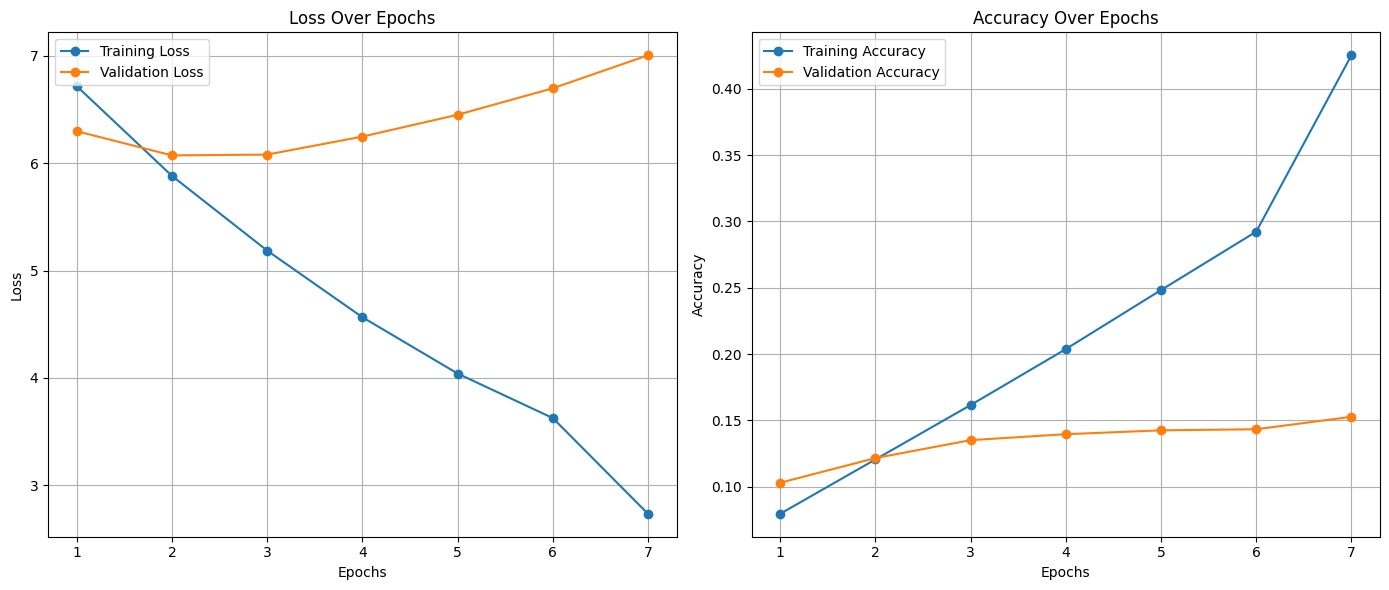

Generated Poem:
the moon shines out shining stars at the side of mornings fruit leaves a shimmer ing dev on his shield that all the pleasant summer gold might never follow and other oh the ale is in theres complete cried set up to set the room the hoary air is heard on the bring slope par rie their blithe companion with whi ps and blossom still flashing as with hollow moans was the noiseless passing for a shrill tale had stained the secret sp rig of gold the lithe st ons entered ride ab ou ched up for their crest and cla p their


In [ ]:
import pandas as pd
import nltk
import re
import torch
import torch.nn as nn
import torch.optim as optim
from tokenizers import Tokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

tokenizer = Tokenizer.from_file("/kaggle/working/bpe_tokenizer.json")
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("<pad>"), pad_token="<pad>")
tokenizer.enable_truncation(max_length=512)

pad_id = tokenizer.token_to_id("<pad>")
print(f"Pad token ID: {pad_id}")

df = pd.read_csv("/kaggle/working/grouped_poems.csv")

VOCAB_SIZE = 10000
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001
SEQ_LENGTH = 100
EARLY_STOPPING_PATIENCE = 5

train_texts, val_texts = train_test_split(df['processed'], test_size=0.1, random_state=42)

class PoetryDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_length):
        self.inputs = []
        self.targets = []
        for text in texts:
            tokens = tokenizer.encode(text).ids
            if len(tokens) > seq_length:
                for i in range(0, len(tokens) - seq_length):
                    self.inputs.append(tokens[i:i+seq_length])
                    self.targets.append(tokens[i+1:i+seq_length+1])
            else:
                padded_tokens = tokens + [pad_id] * (seq_length - len(tokens))
                self.inputs.append(padded_tokens)
                self.targets.append(padded_tokens)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

train_dataset = PoetryDataset(train_texts, tokenizer, SEQ_LENGTH)
val_dataset = PoetryDataset(val_texts, tokenizer, SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class PoetryRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, pad_idx):
        super(PoetryRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out

model = PoetryRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, pad_id).to(device)
print(model)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_train_loss = 0
    correct = 0
    total = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets_flat = targets[:, -1].contiguous().view(-1)
        loss = criterion(outputs, targets_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets_flat.size(0)
        correct += (predicted == targets_flat).sum().item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets_flat = targets[:, -1].contiguous().view(-1)
            loss = criterion(outputs, targets_flat)
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets_flat.size(0)
            correct += (predicted == targets_flat).sum().item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

torch.save(model.state_dict(), "/kaggle/working/poetry_rnn_model.pth")
print("Model saved.")

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

def generate_poetry(model, tokenizer, seed_text, max_length=100):
    model.eval()
    tokens = tokenizer.encode(seed_text).ids
    generated = tokens.copy()
    
    for _ in range(max_length):
        input_seq = generated[-SEQ_LENGTH:] if len(generated) >= SEQ_LENGTH else [pad_id]*(SEQ_LENGTH - len(generated)) + generated
        input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_seq)
            probs = nn.functional.softmax(output, dim=1).cpu().numpy().flatten()
            next_token = np.random.choice(len(probs), p=probs)
            if next_token == pad_id:
                break
            generated.append(next_token)
    
    generated_text = tokenizer.decode(generated)
    return generated_text

seed = "the moon shines"
generated_poem = generate_poetry(model, tokenizer, seed_text=seed, max_length=100)
print("Generated Poem:")
print(generated_poem)


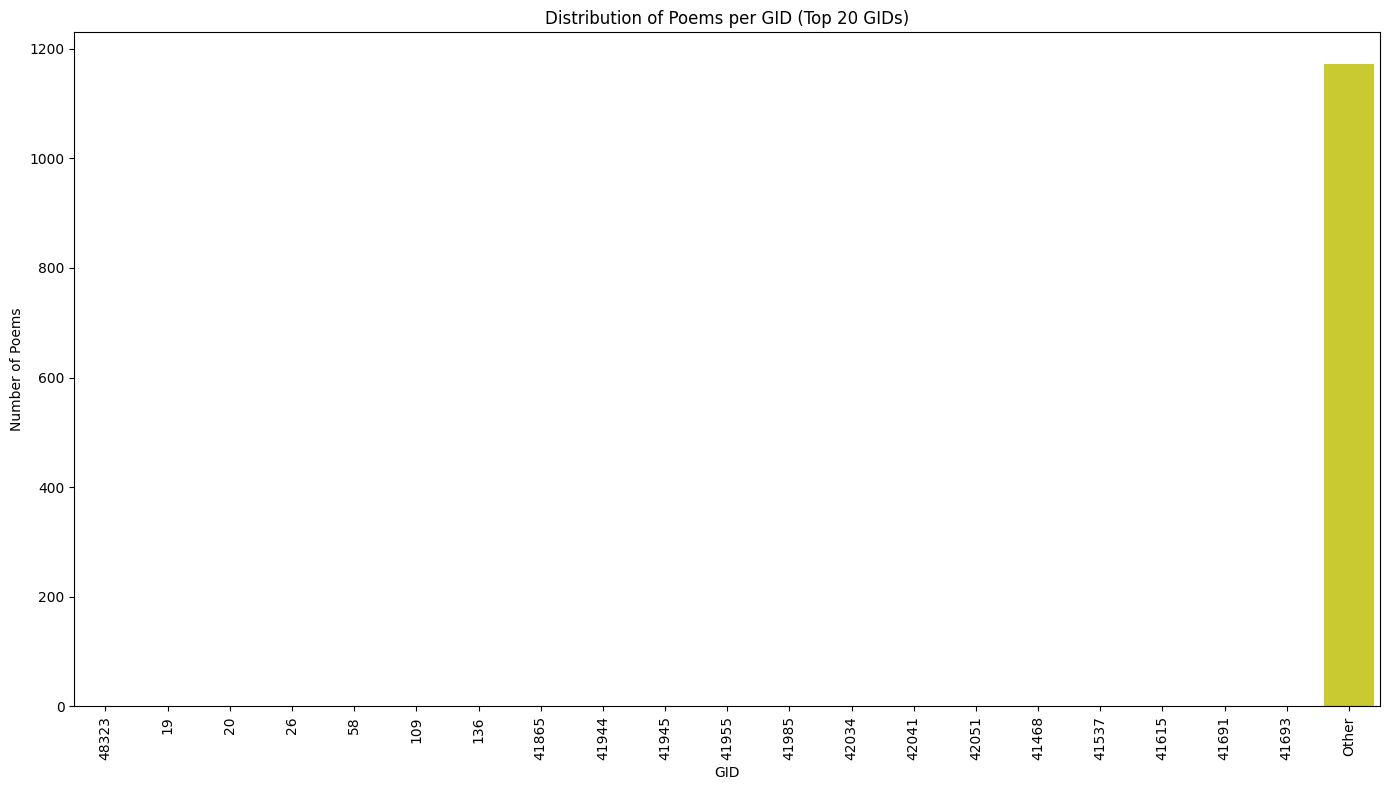

/tmp/ipykernel_30/2986562896.py:68: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


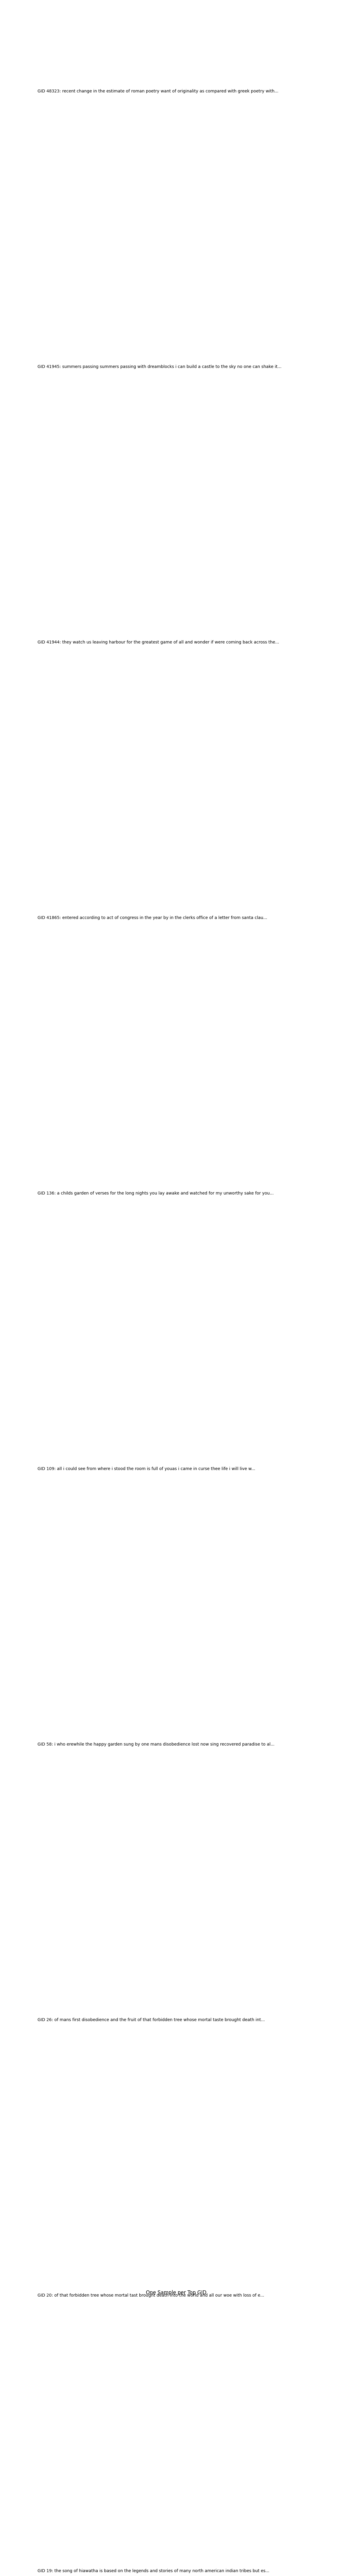

Grouped and processed poems saved.



Tokenizer trained and saved.
Encoded Poem (First Poem): ['the', 'song', 'of', 'hiawatha', 'is', 'b', 'ased', 'on', 'the', 'legends', 'and', 'stories', 'of', 'many', 'north', 'american', 'indian', 'tribes', 'but', 'especially', 'those', 'of', 'the', 'o', 'j', 'ib', 'way', 'ind', 'ians', 'of', 'northern', 'mi', 'ch', 'ig', 'an', 'wis', 'con', 'sin', 'and', 'min', 'nes', 'o', 'ta', 'they', 'were', 'collected', 'by', 'henry', 'row', 'e', 'school', 'craft', 'the', 're', 'known', 'ed', 'school', 'craft', 'married', 'jane', 'o', 'ba', 'h', 'ba', 'h', 'm', 'wa', 'wage', 'z', 'he', 'go', 'qua', 'the', 'fur', 'tra', 'der', 'and', 'o', 'sha', 'ug', 'us', 'co', 'day', 'way', 'qua', 'the', 'woman', 'of', 'the', 'green', 'prairie', 'who', 'was', 'a', 'daughter', 'of', 'wa', 'u', 'bo', 'je', 'eg', 'the', 'white', 'fisher', 'who', 'was', 'chief', 'of', 'the', 'o', 'j', 'ib', 'way', 'tribe', 'at', 'la', 'poin', 'te', 'wis', 'con', 'sin', 'jane', 'and', 'her', 'moth

In [ ]:
import pandas as pd
import nltk
import re
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from nltk.tokenize import word_tokenize
import os
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["TOKENIZERS_PARALLELISM"] = "false"

df = pd.read_csv("/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv")
grouped_poems = df.groupby('gid')['s'].apply(' '.join).reset_index()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

grouped_poems['processed'] = grouped_poems['s'].apply(preprocess_text)

grouped_poems.to_csv("/kaggle/working/grouped_poems.csv", index=False)
print("Grouped and processed poems saved.")

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=10000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
)

tokenizer.train_from_iterator(grouped_poems['processed'], trainer=trainer)

tokenizer.save("/kaggle/working/bpe_tokenizer.json")
print("Tokenizer trained and saved.")

encoded = tokenizer.encode(grouped_poems['processed'][0])

print("Encoded Poem (First Poem):", encoded.tokens)


One Sample per Class:
GID: 19
Poem:
the song of hiawatha is based on the legends and stories of many north american indian tribes but especially those of the ojibway indians of northern michigan wisconsin and minnesota they were collected by henry rowe schoolcraft the reknowned schoolcraft married jane obahbahmwawagezhegoqua the fur trader and oshauguscodaywayqua the woman of the green prairie who was a daughter of waubojeeg the white fisher who was chief of the ojibway tribe at la pointe wisconsin jane and her mother are credited with having researched authenticated and compiled much of the material schoolcraft included in his algic researches and a revision published in as the myth of hiawatha it was this latter revision that longfellow used as the basis for the song of hiawatha longfellow began hiawatha on june he completed it soon as the poem was published its popularity was assured however it also was severely criticized as a plagiary of the finnish epic poem kalevala longfellow m

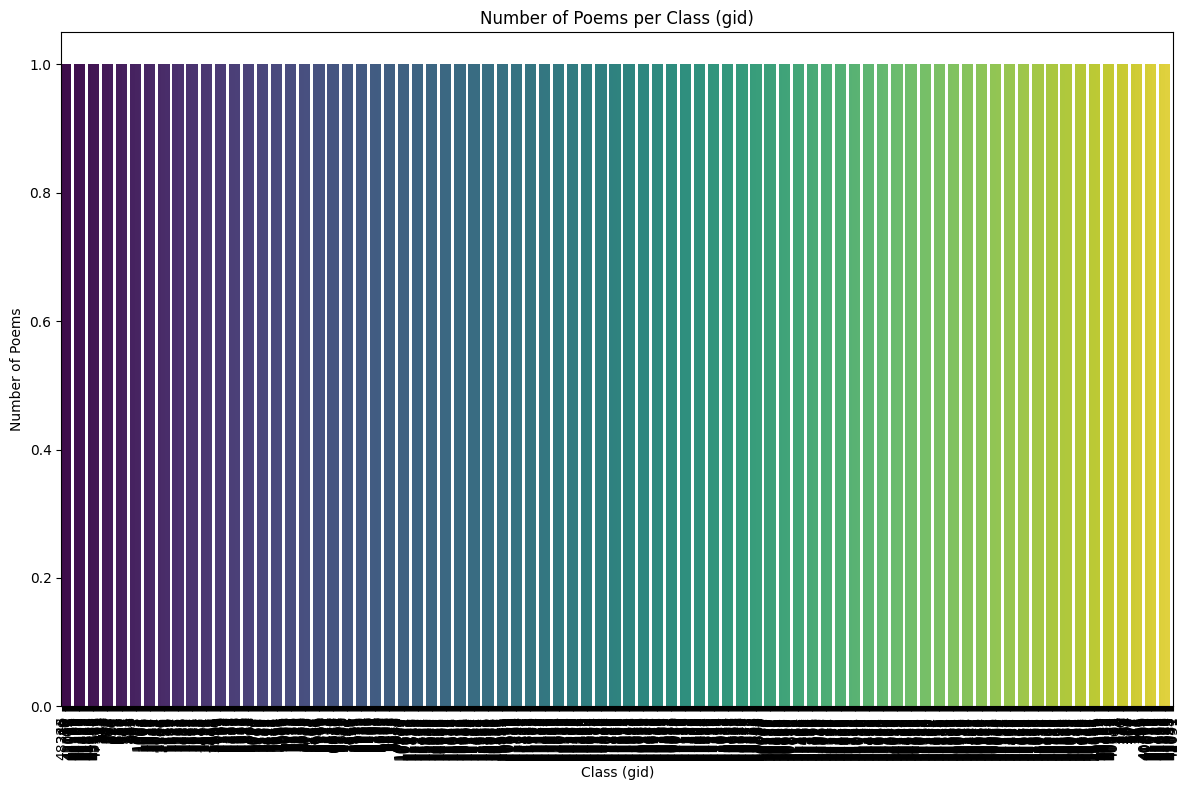

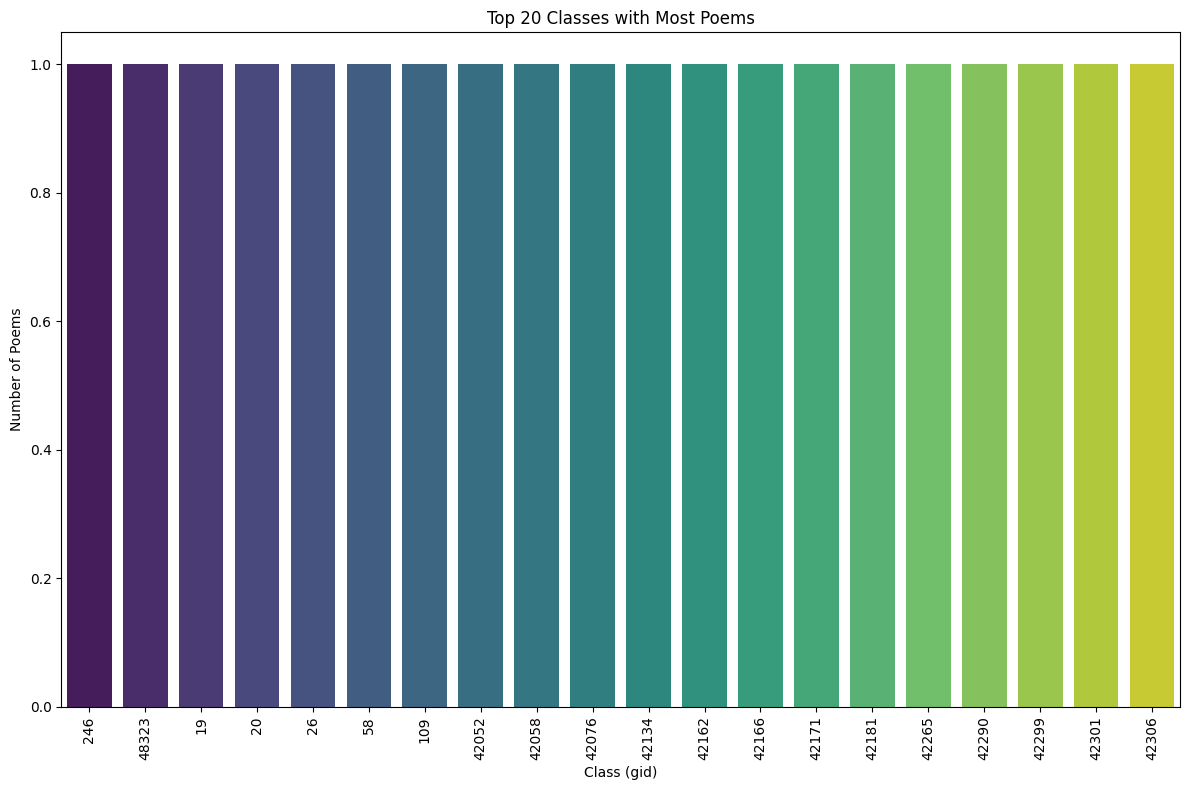

Grouped and processed poems saved.



Tokenizer trained and saved.
Encoded Poem (First Poem): ['the', 'song', 'of', 'hiawatha', 'is', 'b', 'ased', 'on', 'the', 'legends', 'and', 'stories', 'of', 'many', 'north', 'american', 'indian', 'tribes', 'but', 'especially', 'those', 'of', 'the', 'o', 'j', 'ib', 'way', 'ind', 'ians', 'of', 'northern', 'mi', 'ch', 'ig', 'an', 'wis', 'con', 'sin', 'and', 'min', 'nes', 'o', 'ta', 'they', 'were', 'collected', 'by', 'henry', 'row', 'e', 'school', 'craft', 'the', 're', 'known', 'ed', 'school', 'craft', 'married', 'jane', 'o', 'ba', 'h', 'ba', 'h', 'm', 'wa', 'wage', 'z', 'he', 'go', 'qua', 'the', 'fur', 'tra', 'der', 'and', 'o', 'sha', 'ug', 'us', 'co', 'day', 'way', 'qua', 'the', 'woman', 'of', 'the', 'green', 'prairie', 'who', 'was', 'a', 'daughter', 'of', 'wa', 'u', 'bo', 'je', 'eg', 'the', 'white', 'fisher', 'who', 'was', 'chief', 'of', 'the', 'o', 'j', 'ib', 'way', 'tribe', 'at', 'la', 'poin', 'te', 'wis', 'con', 'sin', 'jane', 'and', 'her', 'moth

In [ ]:

import pandas as pd
import nltk
import re
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from nltk.tokenize import word_tokenize
import os
import matplotlib.pyplot as plt
import seaborn as sns


os.environ["TOKENIZERS_PARALLELISM"] = "false"


df = pd.read_csv("/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv")
grouped_poems = df.groupby('gid')['s'].apply(' '.join).reset_index()


def preprocess_text(text):
   
    text = text.lower()
    
    
    text = re.sub(r'[^a-z\s]', '', text)  
    text = re.sub(r'\s+', ' ', text)  

    return text


grouped_poems['processed'] = grouped_poems['s'].apply(preprocess_text)


one_sample_per_class = grouped_poems.groupby('gid').first().reset_index()


print("One Sample per Class:")
for idx, row in one_sample_per_class.head(5).iterrows():
    print(f"GID: {row['gid']}\nPoem:\n{row['processed']}\n{'-'*50}")


class_counts = grouped_poems['gid'].value_counts().sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values, palette="viridis")
plt.title('Number of Poems per Class (gid)')
plt.xlabel('Class (gid)')
plt.ylabel('Number of Poems')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()


top_n = 20
top_classes = class_counts.head(top_n)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_classes.index.astype(str), y=top_classes.values, palette="viridis")
plt.title(f'Top {top_n} Classes with Most Poems')
plt.xlabel('Class (gid)')
plt.ylabel('Number of Poems')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


grouped_poems.to_csv("/kaggle/working/grouped_poems.csv", index=False)
print("Grouped and processed poems saved.")


tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()


trainer = trainers.BpeTrainer(
    vocab_size=10000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>"]
)


tokenizer.train_from_iterator(grouped_poems['processed'], trainer=trainer)


tokenizer.save("/kaggle/working/bpe_tokenizer.json")
print("Tokenizer trained and saved.")


encoded = tokenizer.encode(grouped_poems['processed'][0])  


print("Encoded Poem (First Poem):", encoded.tokens)



Using device: cuda
Pad token ID: 0


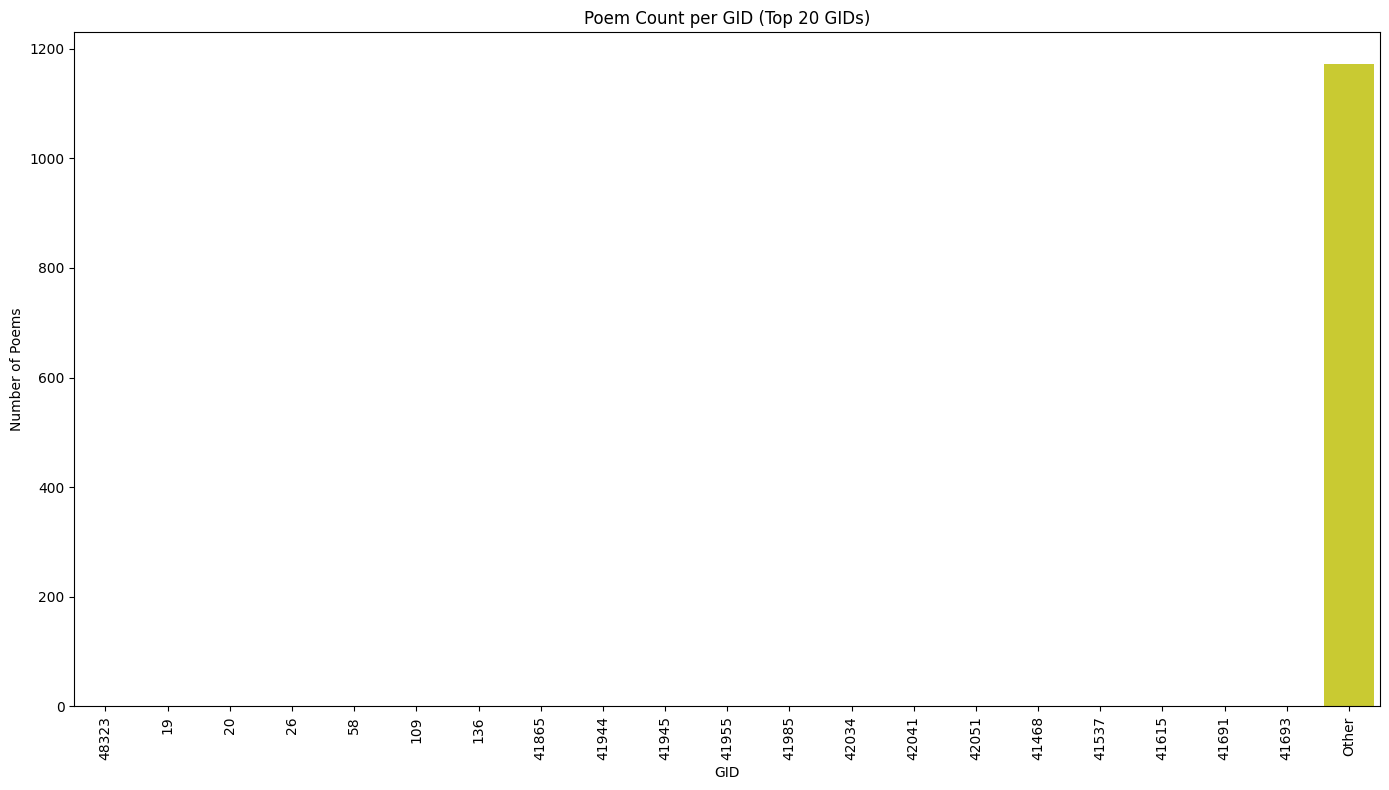

Number of training samples: 432287
Number of validation samples: 48142


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


PoetryRNN(
  (embedding): Embedding(10000, 256, padding_idx=0)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (batch_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (attention): Linear(in_features=1024, out_features=1, bias=True)
  (fc): Linear(in_features=1024, out_features=10000, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Epoch 1 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.69it/s]


Epoch 1 Summary:
Train Loss: 6.8065 | Train Acc: 0.0736
Val Loss: 6.4425 | Val Acc: 0.0911


Epoch 2 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.57it/s]


Epoch 2 Summary:
Train Loss: 6.2322 | Train Acc: 0.0964
Val Loss: 6.1815 | Val Acc: 0.1051


Epoch 3 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.72it/s]


Epoch 3 Summary:
Train Loss: 5.8251 | Train Acc: 0.1197
Val Loss: 6.0390 | Val Acc: 0.1199


Epoch 4 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.63it/s]


Epoch 4 Summary:
Train Loss: 5.4665 | Train Acc: 0.1422
Val Loss: 5.9741 | Val Acc: 0.1309


Epoch 5 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.58it/s]


Epoch 5 Summary:
Train Loss: 5.1300 | Train Acc: 0.1645
Val Loss: 6.0038 | Val Acc: 0.1387
EarlyStopping counter: 1 out of 5


Epoch 6 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.48it/s]


Epoch 6 Summary:
Train Loss: 4.8005 | Train Acc: 0.1882
Val Loss: 6.0207 | Val Acc: 0.1426
EarlyStopping counter: 2 out of 5


Epoch 7 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.62it/s]


Epoch 7 Summary:
Train Loss: 4.4755 | Train Acc: 0.2127
Val Loss: 6.0932 | Val Acc: 0.1485
EarlyStopping counter: 3 out of 5


Epoch 8 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.69it/s]


Epoch 8 Summary:
Train Loss: 4.1772 | Train Acc: 0.2396
Val Loss: 6.2042 | Val Acc: 0.1506
EarlyStopping counter: 4 out of 5


Epoch 9 Validation: 100%|██████████| 753/753 [00:40<00:00, 18.65it/s]


Epoch 9 Summary:
Train Loss: 3.3915 | Train Acc: 0.3280
Val Loss: 6.6041 | Val Acc: 0.1588
EarlyStopping counter: 5 out of 5
Early stopping triggered.
Model saved.


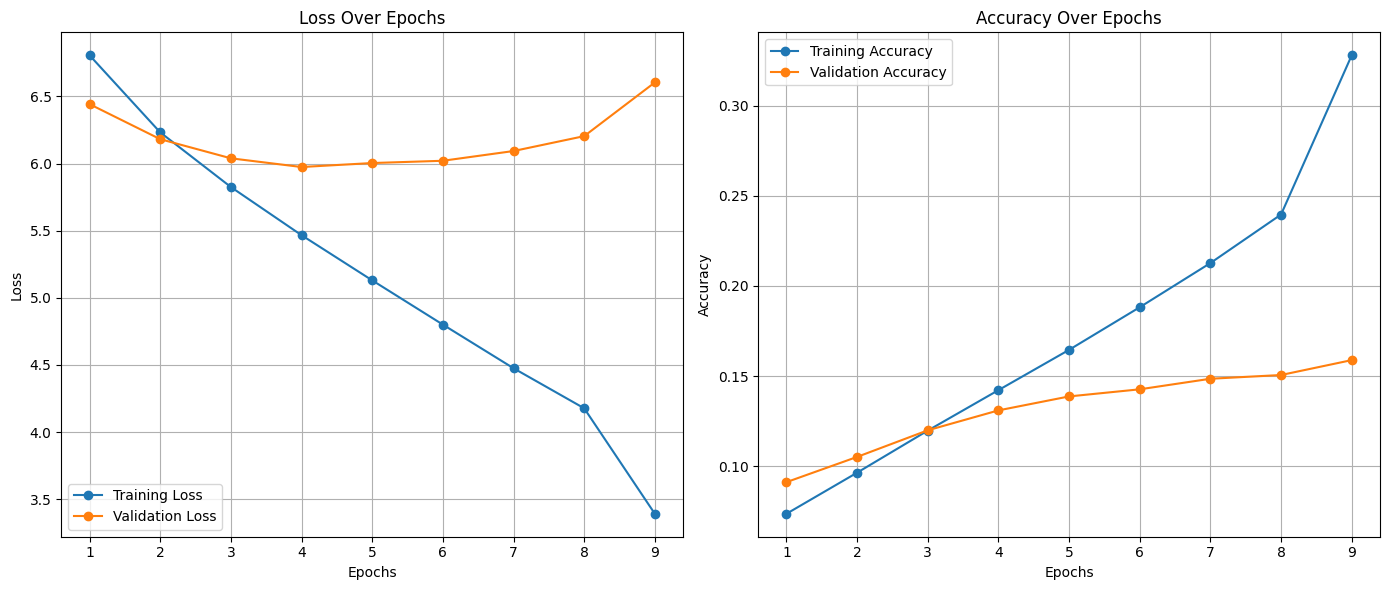

Generated Poem:
the moon shines far removed from heaven li lt ing perpetual so vast a weird delicate grace on our ken ned as the solemn air to fall when ams are born she is born in a bd penelope dome the face of this new dawn i wandered on way or laid with him torrents therefore thrust alike are hurled in with re front of thy gos si les with my visible heart acqu ain in a brethren proud spirit wretched in tears the ruined gleaming heart of thy bow that thunder stricken the round world sat lac accor the lines of the mb


In [ ]:
import pandas as pd
import nltk
import re
import torch
import torch.nn as nn
import torch.optim as optim
from tokenizers import Tokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import random
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

tokenizer = Tokenizer.from_file("/kaggle/working/bpe_tokenizer.json")
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("<pad>"), pad_token="<pad>")
tokenizer.enable_truncation(max_length=512)

pad_id = tokenizer.token_to_id("<pad>")
print(f"Pad token ID: {pad_id}")

df = pd.read_csv("/kaggle/working/grouped_poems.csv")

TOP_N = 20

gid_counts = df['gid'].value_counts()

top_gids = gid_counts.nlargest(TOP_N).index
df['gid_category'] = df['gid'].apply(lambda x: x if x in top_gids else 'Other')

plt.figure(figsize=(14, 8))
sns.countplot(x='gid_category', data=df, palette='viridis', order=gid_counts.nlargest(TOP_N).index.tolist() + ['Other'])
plt.title(f'Poem Count per GID (Top {TOP_N} GIDs)')
plt.xlabel('GID')
plt.ylabel('Number of Poems')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

VOCAB_SIZE = 10000
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.0005
SEQ_LENGTH = 100
EARLY_STOPPING_PATIENCE = 5
WEIGHT_DECAY = 1e-5

train_texts, val_texts = train_test_split(df['processed'], test_size=0.1, random_state=42)

class PoetryDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_length):
        self.inputs = []
        self.targets = []
        for text in texts:
            tokens = tokenizer.encode(text).ids
            if len(tokens) > seq_length:
                for i in range(0, len(tokens) - seq_length):
                    self.inputs.append(tokens[i:i+seq_length])
                    self.targets.append(tokens[i+1:i+seq_length+1])
            else:
                padded_tokens = tokens + [pad_id] * (seq_length - len(tokens))
                self.inputs.append(padded_tokens)
                self.targets.append(padded_tokens)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

train_dataset = PoetryDataset(train_texts, tokenizer, SEQ_LENGTH)
val_dataset = PoetryDataset(val_texts, tokenizer, SEQ_LENGTH)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class PoetryRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, pad_idx):
        super(PoetryRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True, 
            dropout=0.3, 
            bidirectional=True
        )
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out_reshaped = lstm_out.contiguous().view(-1, lstm_out.shape[2])
        lstm_out_norm = self.batch_norm(lstm_out_reshaped)
        lstm_out = lstm_out_norm.view(x.size(0), x.size(1), -1)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        context = self.dropout(context)
        out = self.fc(context)
        return out

model = PoetryRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, pad_id).to(device)
print(model)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_train_loss = 0
    correct = 0
    total = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets_flat = targets[:, -1].contiguous().view(-1)
        loss = criterion(outputs, targets_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets_flat.size(0)
        correct += (predicted == targets_flat).sum().item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets_flat = targets[:, -1].contiguous().view(-1)
            loss = criterion(outputs, targets_flat)
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets_flat.size(0)
            correct += (predicted == targets_flat).sum().item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

torch.save(model.state_dict(), "/kaggle/working/poetry_rnn_model.pth")
print("Model saved.")

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

def generate_poetry(model, tokenizer, seed_text, max_length=100):
    model.eval()
    tokens = tokenizer.encode(seed_text).ids
    generated = tokens.copy()
    
    for _ in range(max_length):
        if len(generated) >= SEQ_LENGTH:
            input_seq = generated[-SEQ_LENGTH:]
        else:
            input_seq = [pad_id] * (SEQ_LENGTH - len(generated)) + generated
        input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_seq)
            probs = nn.functional.softmax(output, dim=1).cpu().numpy().flatten()
            next_token = np.random.choice(len(probs), p=probs)
            if next_token == pad_id:
                break
            generated.append(next_token)
    
    generated_text = tokenizer.decode(generated)
    return generated_text

seed = "the moon shines"
generated_poem = generate_poetry(model, tokenizer, seed_text=seed, max_length=100)
print("Generated Poem:")
print(generated_poem)


Using device: cuda
Grouped and processed poems saved.



Tokenizer trained and saved.
Encoded Poem (First Poem): ['the', 'song', 'of', 'hiawatha', 'is', 'b', 'ased', 'on', 'the', 'legends', 'and', 'stories', 'of', 'many', 'north', 'american', 'indian', 'tribes', ',', 'but', 'especially', 'those', 'of', 'the', 'o', 'j', 'ib', 'way', 'ind', 'ians', 'of', 'northern', 'mi', 'chi', 'gan', ',', 'wis', 'con', 'sin', ',', 'and', 'min', 'nes', 'o', 'ta', '.', 'they', 'were', 'collected', 'by', 'henry', 'row', 'e', 'school', 'craft', ',', 'the', 're', 'know', 'ned', 'school', 'craft', 'married', 'jane', ',', 'o', 'ba', 'h', 'ba', 'h', 'm', 'wa', 'wage', 'z', 'he', 'go', 'qua', 'the', 'fur', 'tra', 'der', ',', 'and', 'o', 'sha', 'ug', 'us', 'co', 'day', 'way', 'qua', 'the', 'woman', 'of', 'the', 'green', 'prairie', ',', 'who', 'was', 'a', 'daughter', 'of', 'wa', 'u', 'bo', 'je', 'eg', 'the', 'white', 'fisher', ',', 'who', 'was', 'chief', 'of', 'the', 'o', 'j', 'ib', 'way', 'tribe', 'at', 'la', 'p

Epoch 1 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.26it/s]


Epoch 1 Summary:
Train Loss: 6.2036 | Train Perplexity: 494.5118 | Train Acc: 0.1236
Val Loss: 5.8244 | Val Perplexity: 338.4558 | Val Acc: 0.1443
Current Learning Rate: 0.001000



Epoch 2 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.30it/s]


Epoch 2 Summary:
Train Loss: 5.6334 | Train Perplexity: 279.6176 | Train Acc: 0.1472
Val Loss: 5.6454 | Val Perplexity: 282.9789 | Val Acc: 0.1566
Current Learning Rate: 0.001000



Epoch 3 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.29it/s]


Epoch 3 Summary:
Train Loss: 5.2956 | Train Perplexity: 199.4619 | Train Acc: 0.1616
Val Loss: 5.6102 | Val Perplexity: 273.1895 | Val Acc: 0.1647
Current Learning Rate: 0.001000



Epoch 4 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.26it/s]


Epoch 4 Summary:
Train Loss: 5.0133 | Train Perplexity: 150.3986 | Train Acc: 0.1748
Val Loss: 5.6253 | Val Perplexity: 277.3689 | Val Acc: 0.1684
Current Learning Rate: 0.001000

EarlyStopping counter: 1 out of 10


Epoch 5 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.41it/s]


Epoch 5 Summary:
Train Loss: 4.7506 | Train Perplexity: 115.6522 | Train Acc: 0.1885
Val Loss: 5.6805 | Val Perplexity: 293.1080 | Val Acc: 0.1733
Current Learning Rate: 0.001000

EarlyStopping counter: 2 out of 10


Epoch 6 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.25it/s]


Epoch 6 Summary:
Train Loss: 4.5000 | Train Perplexity: 90.0152 | Train Acc: 0.2047
Val Loss: 5.7600 | Val Perplexity: 317.3362 | Val Acc: 0.1746
Current Learning Rate: 0.001000

EarlyStopping counter: 3 out of 10


Epoch 7 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.34it/s]


Epoch 7 Summary:
Train Loss: 4.2533 | Train Perplexity: 70.3385 | Train Acc: 0.2220
Val Loss: 5.7685 | Val Perplexity: 320.0526 | Val Acc: 0.1801
Current Learning Rate: 0.000500

EarlyStopping counter: 4 out of 10


Epoch 8 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.43it/s]


Epoch 8 Summary:
Train Loss: 3.7011 | Train Perplexity: 40.4923 | Train Acc: 0.2759
Val Loss: 6.0702 | Val Perplexity: 432.7546 | Val Acc: 0.1810
Current Learning Rate: 0.000500

EarlyStopping counter: 5 out of 10


Epoch 9 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.38it/s]


Epoch 9 Summary:
Train Loss: 3.4644 | Train Perplexity: 31.9588 | Train Acc: 0.3025
Val Loss: 6.1525 | Val Perplexity: 469.9022 | Val Acc: 0.1811
Current Learning Rate: 0.000500

EarlyStopping counter: 6 out of 10


Epoch 10 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.37it/s]


Epoch 10 Summary:
Train Loss: 3.2885 | Train Perplexity: 26.8024 | Train Acc: 0.3220
Val Loss: 6.3296 | Val Perplexity: 560.9319 | Val Acc: 0.1809
Current Learning Rate: 0.000500

EarlyStopping counter: 7 out of 10


Epoch 11 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.32it/s]


Epoch 11 Summary:
Train Loss: 3.1369 | Train Perplexity: 23.0335 | Train Acc: 0.3414
Val Loss: 6.4181 | Val Perplexity: 612.8538 | Val Acc: 0.1797
Current Learning Rate: 0.000250

EarlyStopping counter: 8 out of 10


Epoch 12 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.36it/s]


Epoch 12 Summary:
Train Loss: 2.7796 | Train Perplexity: 16.1123 | Train Acc: 0.3943
Val Loss: 6.6332 | Val Perplexity: 759.8846 | Val Acc: 0.1801
Current Learning Rate: 0.000250

EarlyStopping counter: 9 out of 10


Epoch 13 Validation: 100%|██████████| 940/940 [00:48<00:00, 19.51it/s]


Epoch 13 Summary:
Train Loss: 2.6597 | Train Perplexity: 14.2926 | Train Acc: 0.4121
Val Loss: 6.7785 | Val Perplexity: 878.7337 | Val Acc: 0.1772
Current Learning Rate: 0.000250

EarlyStopping counter: 10 out of 10
Early stopping triggered.
Model saved.


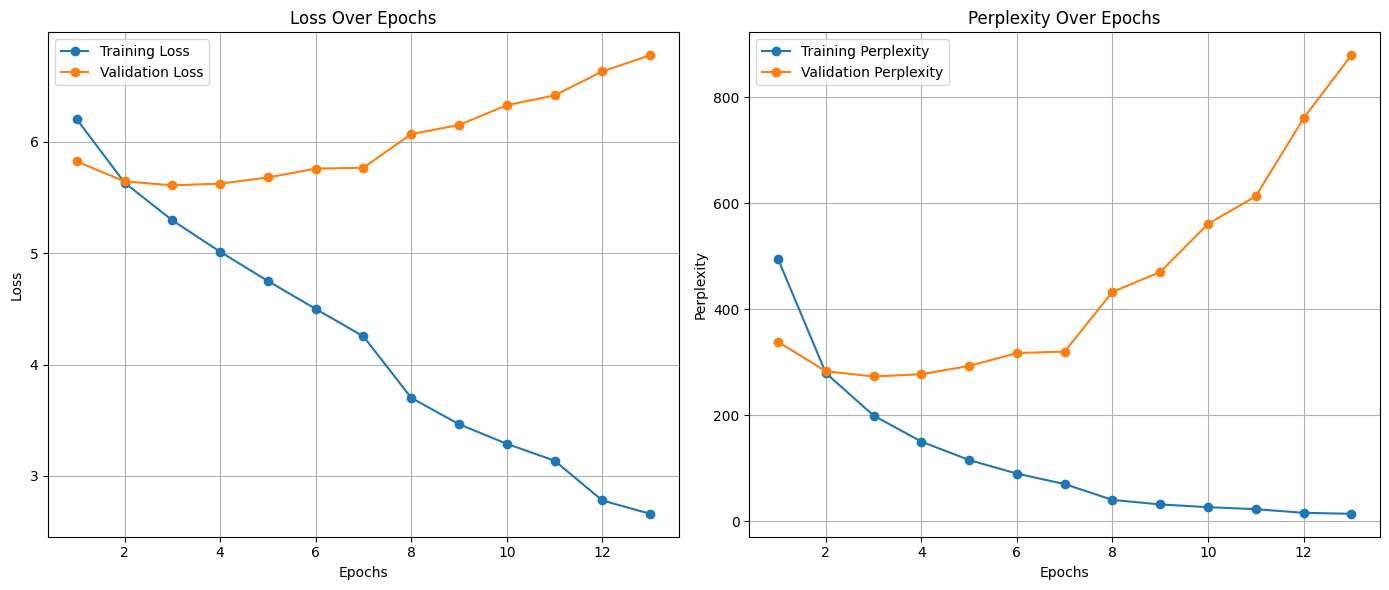

/tmp/ipykernel_30/1279232724.py:362: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/poetry_rnn_model.pth"))


Generated Poetry:
the moon shines through maiden creatures of the world , beloved , awake ! fest thoughts of all , with its better ring in the deep of that realm ! but who , yesterday , the traitor grin ned to me , my heart will ra bble , while all my others do unfold my darling deeds : beneath the dark , there ' s none of thy army for hours , satisfied tread in ' treasure once again ; the tears is grown to win , and in vain home apart i see thee sung the foam of song . a white j ged thought made rather green and strong , the sound of troops seem to lee before the cheeks of human majesty . the name of winter show ! then away to the souls depart , to raise the coffin inscri bed . go forth ! upon the car ri ers to the stars unfur l ; beneath the violet the lark sings to the truly white . t welf th ' chor ! cher ' s lay fay s the war clang for the lover who sees where the war creatures runs their poor way ; heaven sister with


In [ ]:
import pandas as pd
import nltk
import re
import torch
import torch.nn as nn
import torch.optim as optim
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import os
import seaborn as sns

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

df = pd.read_csv("/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv")
grouped_poems = df.groupby('gid')['s'].apply(' '.join).reset_index()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s\.,!?;:\'\n]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', '\n', text)
    return text

grouped_poems['processed'] = grouped_poems['s'].apply(preprocess_text)
grouped_poems = grouped_poems[grouped_poems['processed'].str.len() > 50].reset_index(drop=True)
grouped_poems['processed'] = grouped_poems['processed'].str.replace('\n', ' <newline> ')
grouped_poems.to_csv("/kaggle/working/grouped_poems.csv", index=False)
print("Grouped and processed poems saved.")

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=10000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>", "<newline>"]
)

tokenizer.train_from_iterator(grouped_poems['processed'], trainer=trainer)
tokenizer.save("/kaggle/working/bpe_tokenizer.json")
print("Tokenizer trained and saved.")

encoded = tokenizer.encode(grouped_poems['processed'][0])
print("Encoded Poem (First Poem):", encoded.tokens)

tokenizer = Tokenizer.from_file("/kaggle/working/bpe_tokenizer.json")
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("<pad>"), pad_token="<pad>")
tokenizer.enable_truncation(max_length=512)

pad_id = tokenizer.token_to_id("<pad>")
unk_id = tokenizer.token_to_id("<unk>")
newline_id = tokenizer.token_to_id("<newline>")
print(f"Pad token ID: {pad_id}, Unknown token ID: {unk_id}, Newline token ID: {newline_id}")

VOCAB_SIZE = 10000
EMBEDDING_DIM = 256
HIDDEN_DIM = 512
NUM_LAYERS = 2
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.001
SEQ_LENGTH = 100
EARLY_STOPPING_PATIENCE = 10

train_texts, val_texts = train_test_split(df['processed'], test_size=0.1, random_state=42)

class PoetryDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_length):
        self.inputs = []
        self.targets = []
        for text in texts:
            tokens = tokenizer.encode(text).ids
            if len(tokens) < 2:
                continue
            for i in range(1, len(tokens)):
                input_seq = tokens[:i]
                target_seq = tokens[1:i+1]
                if len(input_seq) > seq_length:
                    input_seq = input_seq[-seq_length:]
                    target_seq = target_seq[-seq_length:]
                else:
                    padding_length = seq_length - len(input_seq)
                    input_seq = [pad_id] * padding_length + input_seq
                    target_seq = [pad_id] * padding_length + target_seq
                self.inputs.append(input_seq)
                self.targets.append(target_seq)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

train_dataset = PoetryDataset(train_texts, tokenizer, SEQ_LENGTH)
val_dataset = PoetryDataset(val_texts, tokenizer, SEQ_LENGTH)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class PoetryRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, pad_idx):
        super(PoetryRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.batch_norm_emb = nn.BatchNorm1d(embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True, 
            dropout=0.2, 
            bidirectional=True
        )
        self.batch_norm_lstm = nn.BatchNorm1d(hidden_dim * 2)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        embedded = self.batch_norm_emb(embedded)
        embedded = embedded.permute(0, 2, 1)
        embedded = self.dropout(embedded)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.batch_norm_lstm(lstm_out)
        lstm_out = lstm_out.permute(0, 2, 1)
        lstm_out = self.dropout(lstm_out)
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        out = self.fc(context)
        return out

model = PoetryRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, pad_id).to(device)
print(model)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True)

def calculate_perplexity(loss):
    return np.exp(loss)

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []

current_lr = LEARNING_RATE

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_train_loss = 0
    correct = 0
    total = 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets_flat = targets[:, -1].contiguous().view(-1)
        loss = criterion(outputs, targets_flat)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets_flat.size(0)
        correct += (predicted == targets_flat).sum().item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_perplexities.append(calculate_perplexity(avg_train_loss))
    train_accuracy = correct / total
    
    model.eval()
    epoch_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets_flat = targets[:, -1].contiguous().view(-1)
            loss = criterion(outputs, targets_flat)
            epoch_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets_flat.size(0)
            correct += (predicted == targets_flat).sum().item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_perplexities.append(calculate_perplexity(avg_val_loss))
    val_accuracy = correct / total
    
    scheduler.step(avg_val_loss)
    
    current_lr = scheduler.get_last_lr()[0]
    
    print(f"Epoch {epoch} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Perplexity: {train_perplexities[-1]:.4f} | Train Acc: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Perplexity: {val_perplexities[-1]:.4f} | Val Acc: {val_accuracy:.4f}")
    print(f"Current Learning Rate: {current_lr:.6f}\n")
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

torch.save(model.state_dict(), "/kaggle/working/poetry_rnn_model.pth")
print("Model saved.")

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_perplexities, label='Training Perplexity', marker='o')
plt.plot(epochs_range, val_perplexities, label='Validation Perplexity', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

def generate_poetry(model, tokenizer, seed_text, max_length=100, temperature=1.0):
    model.eval()
    tokens = tokenizer.encode(seed_text).ids
    generated = tokens.copy()
    
    for _ in range(max_length):
        if len(generated) >= SEQ_LENGTH:
            input_seq = generated[-SEQ_LENGTH:]
        else:
            input_seq = [pad_id] * (SEQ_LENGTH - len(generated)) + generated
        input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_seq)
            logits = output / temperature
            probs = nn.functional.softmax(logits, dim=1).cpu().numpy().flatten()
            next_token = np.random.choice(len(probs), p=probs)
            if next_token == pad_id or next_token == newline_id:
                break
            generated.append(next_token)
    
    generated_text = tokenizer.decode(generated)
    return generated_text

model = PoetryRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, pad_id).to(device)
model.load_state_dict(torch.load("/kaggle/working/poetry_rnn_model.pth"))
model.eval()

seed = "the moon shines"
generated_poem = generate_poetry(model, tokenizer, seed_text=seed, max_length=200, temperature=1.0)
print("Generated Poetry:")
print(generated_poem)


In [ ]:
import pandas as pd
import nltk
import re
import torch
import torch.nn as nn
import torch.optim as optim
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

df = pd.read_csv("/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv")
grouped_poems = df.groupby('gid')['s'].apply(' '.join).reset_index()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s\.,!?;:\'\n]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', '\n', text)
    return text

grouped_poems['processed'] = grouped_poems['s'].apply(preprocess_text)
grouped_poems = grouped_poems[grouped_poems['processed'].str.len() > 50].reset_index(drop=True)
grouped_poems['processed'] = grouped_poems['processed'].str.replace('\n', ' <newline> ')
grouped_poems.to_csv("/kaggle/working/grouped_poems.csv", index=False)
print("Grouped and processed poems saved.")

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=10000,
    min_frequency=2,
    show_progress=True,
    special_tokens=["<pad>", "<unk>", "<s>", "</s>", "<newline>"]
)

tokenizer.train_from_iterator(grouped_poems['processed'], trainer=trainer)
tokenizer.save("/kaggle/working/bpe_tokenizer.json")
print("Tokenizer trained and saved.")

encoded = tokenizer.encode(grouped_poems['processed'][0])
print("Encoded Poem (First Poem):", encoded.tokens)

tokenizer = Tokenizer.from_file("/kaggle/working/bpe_tokenizer.json")
tokenizer.enable_padding(pad_id=tokenizer.token_to_id("<pad>"), pad_token="<pad>")
tokenizer.enable_truncation(max_length=512)

pad_id = tokenizer.token_to_id("<pad>")
unk_id = tokenizer.token_to_id("<unk>")
newline_id = tokenizer.token_to_id("<newline>")
print(f"Pad token ID: {pad_id}, Unknown token ID: {unk_id}, Newline token ID: {newline_id}")

VOCAB_SIZE = 10000
EMBEDDING_DIM = 512
HIDDEN_DIM = 1024
NUM_LAYERS = 3
BATCH_SIZE = 128
EPOCHS = 16
LEARNING_RATE = 0.001
SEQ_LENGTH = 100
EARLY_STOPPING_PATIENCE = 5

train_texts, val_texts = train_test_split(df['processed'], test_size=0.1, random_state=42)

class PoetryDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_length):
        self.inputs = []
        self.targets = []
        for text in texts:
            tokens = tokenizer.encode(text).ids
            if len(tokens) < 2:
                continue
            for i in range(SEQ_LENGTH, len(tokens)):
                input_seq = tokens[i - SEQ_LENGTH:i]
                target = tokens[i]
                self.inputs.append(input_seq)
                self.targets.append(target)
        
        self.inputs = torch.tensor(self.inputs, dtype=torch.long)
        self.targets = torch.tensor(self.targets, dtype=torch.long)
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = PoetryDataset(train_texts, tokenizer, SEQ_LENGTH)
val_dataset = PoetryDataset(val_texts, tokenizer, SEQ_LENGTH)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

class PoetryRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, pad_idx):
        super(PoetryRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.layer_norm_emb = nn.LayerNorm(embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.layer_norm_lstm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.layer_norm_emb(embedded)
        embedded = self.dropout(embedded)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.layer_norm_lstm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        return out

model = PoetryRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, pad_id).to(device)
print(model)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.verbose:
                print(f'Initial validation loss set to {val_loss:.4f}')
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f'Validation loss decreased to {val_loss:.4f}. Resetting counter.')
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=True)

def calculate_perplexity(loss):
    return np.exp(loss)

train_losses = []
val_losses = []
train_perplexities = []
val_perplexities = []
train_accuracies = []
val_accuracies = []
train_f1 = []
val_f1 = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_train_loss = 0
    all_preds = []
    all_targets = []
    
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        epoch_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_perplexities.append(calculate_perplexity(avg_train_loss))
    
    train_accuracy = accuracy_score(all_targets, all_preds)
    train_f1_score = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
    train_accuracies.append(train_accuracy)
    train_f1.append(train_f1_score)
    
    model.eval()
    epoch_val_loss = 0
    all_preds_val = []
    all_targets_val = []
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds_val.extend(predicted.cpu().numpy())
            all_targets_val.extend(targets.cpu().numpy())
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_perplexities.append(calculate_perplexity(avg_val_loss))
    
    val_accuracy = accuracy_score(all_targets_val, all_preds_val)
    val_f1_score = f1_score(all_targets_val, all_preds_val, average='weighted', zero_division=0)
    val_accuracies.append(val_accuracy)
    val_f1.append(val_f1_score)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch} Summary:")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Perplexity: {train_perplexities[-1]:.4f} | Train Acc: {train_accuracy:.4f} | Train F1: {train_f1_score:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Perplexity: {val_perplexities[-1]:.4f} | Val Acc: {val_accuracy:.4f} | Val F1: {val_f1_score:.4f}\n")
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

torch.save(model.state_dict(), "/kaggle/working/poetry_rnn_model.pth")
print("Model saved.")

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs_range, train_perplexities, label='Training Perplexity', marker='o')
plt.plot(epochs_range, val_perplexities, label='Validation Perplexity', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs_range, train_f1, label='Training F1 Score', marker='o')
plt.plot(epochs_range, val_f1, label='Validation F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

def generate_poetry(model, tokenizer, seed_text, max_length=100, temperature=1.0):
    model.eval()
    tokens = tokenizer.encode(seed_text).ids
    generated = tokens.copy()
    
    for _ in range(max_length):
        if len(generated) >= SEQ_LENGTH:
            input_seq = generated[-SEQ_LENGTH:]
        else:
            input_seq = [pad_id]*(SEQ_LENGTH - len(generated)) + generated
        input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_seq)
            logits = output / temperature
            probs = nn.functional.softmax(logits, dim=1).cpu().numpy().flatten()
            next_token = np.random.choice(len(probs), p=probs)
            if next_token == pad_id or next_token == newline_id:
                break
            generated.append(next_token)
    
    generated_text = tokenizer.decode(generated)
    return generated_text

model = PoetryRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, pad_id).to(device)
model.load_state_dict(torch.load("/kaggle/working/poetry_rnn_model.pth"))
model.eval()

seed = "the moon shines"
generated_poem = generate_poetry(model, tokenizer, seed_text=seed, max_length=200, temperature=1.0)
print("Generated Poetry:")
print(generated_poem)


Using device: cuda
Grouped and processed poems saved.



Tokenizer trained and saved.
Encoded Poem (First Poem): ['the', 'song', 'of', 'hiawatha', 'is', 'b', 'ased', 'on', 'the', 'legends', 'and', 'stories', 'of', 'many', 'north', 'american', 'indian', 'tribes', ',', 'but', 'especially', 'those', 'of', 'the', 'o', 'j', 'ib', 'way', 'ind', 'ians', 'of', 'northern', 'mi', 'chi', 'gan', ',', 'wis', 'con', 'sin', ',', 'and', 'min', 'nes', 'o', 'ta', '.', 'they', 'were', 'collected', 'by', 'henry', 'row', 'e', 'school', 'craft', ',', 'the', 're', 'know', 'ned', 'school', 'craft', 'married', 'jane', ',', 'o', 'ba', 'h', 'ba', 'h', 'm', 'wa', 'wage', 'z', 'he', 'go', 'qua', 'the', 'fur', 'tra', 'der', ',', 'and', 'o', 'sha', 'ug', 'us', 'co', 'day', 'way', 'qua', 'the', 'woman', 'of', 'the', 'green', 'prairie', ',', 'who', 'was', 'a', 'daughter', 'of', 'wa', 'u', 'bo', 'je', 'eg', 'the', 'white', 'fisher', ',', 'who', 'was', 'chief', 'of', 'the', 'o', 'j', 'ib', 'way', 'tribe', 'at', 'la', 'p

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.63it/s]


Epoch 1 Summary:
Train Loss: 6.7807 | Train Perplexity: 880.7228 | Train Acc: 0.0931 | Train F1: 0.0291
Val Loss: 6.8514 | Val Perplexity: 945.2025 | Val Acc: 0.1031 | Val F1: 0.0322

Initial validation loss set to 6.8514


Epoch 2 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.64it/s]


Epoch 2 Summary:
Train Loss: 6.3717 | Train Perplexity: 585.0290 | Train Acc: 0.1140 | Train F1: 0.0409
Val Loss: 6.1558 | Val Perplexity: 471.4567 | Val Acc: 0.1250 | Val F1: 0.0506

Validation loss decreased to 6.1558. Resetting counter.


Epoch 3 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.64it/s]


Epoch 3 Summary:
Train Loss: 6.1169 | Train Perplexity: 453.4695 | Train Acc: 0.1242 | Train F1: 0.0532
Val Loss: 6.0483 | Val Perplexity: 423.3984 | Val Acc: 0.1312 | Val F1: 0.0572

Validation loss decreased to 6.0483. Resetting counter.


Epoch 4 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.63it/s]


Epoch 4 Summary:
Train Loss: 5.9936 | Train Perplexity: 400.8583 | Train Acc: 0.1298 | Train F1: 0.0593
Val Loss: 5.9732 | Val Perplexity: 392.7752 | Val Acc: 0.1355 | Val F1: 0.0640

Validation loss decreased to 5.9732. Resetting counter.


Epoch 5 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.64it/s]


Epoch 5 Summary:
Train Loss: 5.9130 | Train Perplexity: 369.8116 | Train Acc: 0.1331 | Train F1: 0.0632
Val Loss: 5.9234 | Val Perplexity: 373.6858 | Val Acc: 0.1379 | Val F1: 0.0657

Validation loss decreased to 5.9234. Resetting counter.


Epoch 6 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.62it/s]


Epoch 6 Summary:
Train Loss: 5.8429 | Train Perplexity: 344.7871 | Train Acc: 0.1355 | Train F1: 0.0662
Val Loss: 5.8827 | Val Perplexity: 358.7904 | Val Acc: 0.1395 | Val F1: 0.0672

Validation loss decreased to 5.8827. Resetting counter.


Epoch 7 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.62it/s]


Epoch 7 Summary:
Train Loss: 5.7907 | Train Perplexity: 327.2360 | Train Acc: 0.1378 | Train F1: 0.0687
Val Loss: 5.8566 | Val Perplexity: 349.5258 | Val Acc: 0.1403 | Val F1: 0.0693

Validation loss decreased to 5.8566. Resetting counter.


Epoch 8 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.61it/s]


Epoch 8 Summary:
Train Loss: 5.7419 | Train Perplexity: 311.6639 | Train Acc: 0.1395 | Train F1: 0.0708
Val Loss: 5.8284 | Val Perplexity: 339.8179 | Val Acc: 0.1426 | Val F1: 0.0709

Validation loss decreased to 5.8284. Resetting counter.


Epoch 9 Validation: 100%|██████████| 378/378 [01:21<00:00,  4.61it/s]


Epoch 9 Summary:
Train Loss: 5.7024 | Train Perplexity: 299.5742 | Train Acc: 0.1410 | Train F1: 0.0724
Val Loss: 5.8120 | Val Perplexity: 334.2904 | Val Acc: 0.1443 | Val F1: 0.0737

Validation loss decreased to 5.8120. Resetting counter.


Epoch 10 Validation: 100%|██████████| 378/378 [01:22<00:00,  4.61it/s]


Epoch 10 Summary:
Train Loss: 5.6635 | Train Perplexity: 288.1611 | Train Acc: 0.1428 | Train F1: 0.0747
Val Loss: 5.7921 | Val Perplexity: 327.7032 | Val Acc: 0.1462 | Val F1: 0.0768

Validation loss decreased to 5.7921. Resetting counter.


Epoch 11 Validation: 100%|██████████| 378/378 [01:22<00:00,  4.60it/s]


Epoch 11 Summary:
Train Loss: 5.6317 | Train Perplexity: 279.1450 | Train Acc: 0.1437 | Train F1: 0.0758
Val Loss: 5.7972 | Val Perplexity: 329.3711 | Val Acc: 0.1454 | Val F1: 0.0760

EarlyStopping counter: 1 out of 5


Epoch 12 Validation: 100%|██████████| 378/378 [01:22<00:00,  4.60it/s]


Epoch 12 Summary:
Train Loss: 5.6040 | Train Perplexity: 271.5082 | Train Acc: 0.1447 | Train F1: 0.0774
Val Loss: 5.7793 | Val Perplexity: 323.5241 | Val Acc: 0.1467 | Val F1: 0.0779

Validation loss decreased to 5.7793. Resetting counter.


Epoch 13 Training:  93%|█████████▎| 3138/3390 [34:31<02:47,  1.50it/s]